In [250]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor,RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import seaborn as sns
from pyod.models.mad import MAD
import statsmodels.api as sm
from sklearn.linear_model import RANSACRegressor, LinearRegression, TheilSenRegressor, HuberRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, RandomizedSearchCV, cross_val_score

In [251]:
#Load the data
X_train_unfiltered =np.load('X_train.npy')
Y_train_unfiltered =np.load('y_train.npy')
X_test =np.load('X_test.npy')

In [252]:
# Create a dataframe for the training data and standardize the features
train_features = ['Air Temperature','Water Temperature','Wind speed','Wind Direction','Illumination']

#Define the colours for the plots associated with each feature
colours = ['deepskyblue', 'aqua', 'mediumvioletred', 'teal', "gold"]

X_train_unfiltered = pd.DataFrame(X_train_unfiltered)
X_train_unfiltered = X_train_unfiltered.rename(columns={i:train_features[i] for i in range(5)})
y_train_df = pd.DataFrame(Y_train_unfiltered)
y_train_df.rename(columns={0:'y_train'}, inplace=True)
train_data_unfiltered = X_train_unfiltered.copy()
train_data_unfiltered['Y_train'] = y_train_df.reset_index(drop=True)

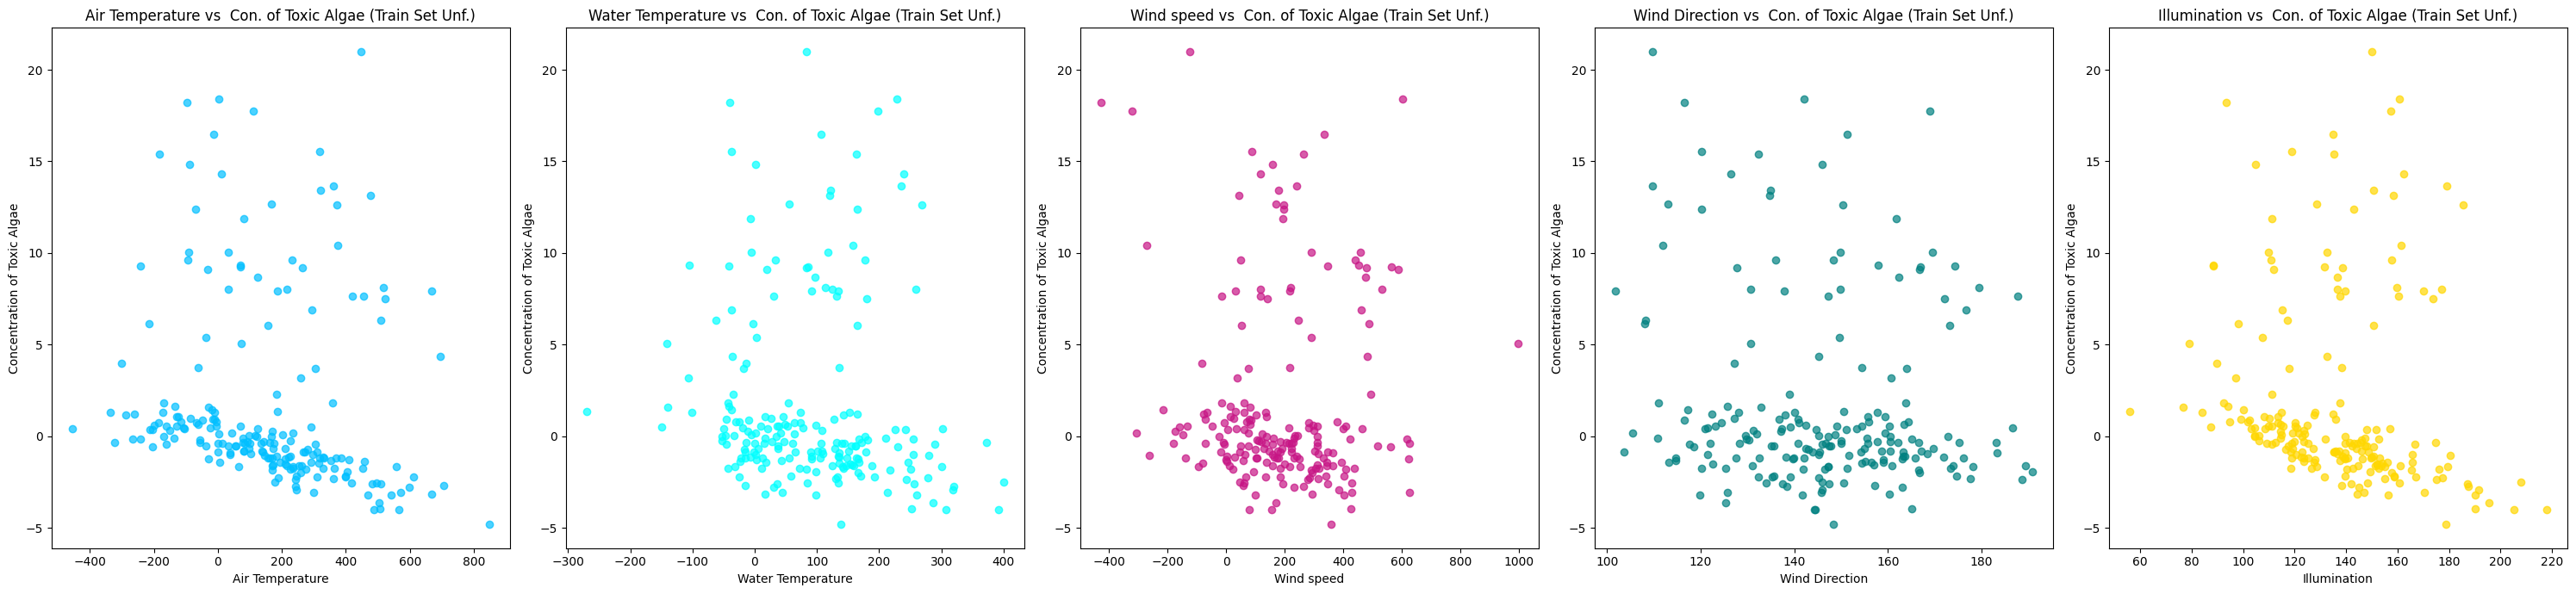

In [253]:
# Plots with training data with outliers to visualize the data
fig, axes = plt.subplots(1, 5, figsize=(30, 7))

for i, feature in enumerate(train_features):
    axes[i].scatter(train_data_unfiltered[feature], train_data_unfiltered['Y_train'], alpha=0.7, color = colours[i])
    axes[i].set_title(f'{feature} vs  Con. of Toxic Algae (Train Set Unf.)')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Concentration of Toxic Algae')

plt.tight_layout() 
plt.show()

**Methods for Outlier Removing**

**1 - Ordinary Linear Regression**

In [254]:
linear_model = LinearRegression()

linear_model.fit(train_data_unfiltered[train_features], train_data_unfiltered['Y_train'])
y_pred_OLS = linear_model.predict(train_data_unfiltered[train_features])
residuals_OLS = np.square(train_data_unfiltered['Y_train'] - y_pred_OLS)
threshold_OLS = np.percentile(residuals_OLS, 75)
least_residual_points_OLS = train_data_unfiltered[residuals_OLS < threshold_OLS]
X_train_OLS, X_val_OLS, Y_train_OLS, Y_val_OLS = train_test_split(least_residual_points_OLS[train_features],least_residual_points_OLS['Y_train'],test_size=0.3, random_state=42)
scaler_OLS = StandardScaler()
X_train_OLS = scaler_OLS.fit_transform(X_train_OLS)
X_val_OLS = scaler_OLS.transform(X_val_OLS)


MSE of OLS: 0.868796101768957
R^2 of OLS: 0.6346377095049076

[[0.0001, 0.635795067547921], [0.001, 0.6384441285840767], [0.01, 0.6398291075127077], [0.1, 0.6484667739055499], [0.2, 0.6591155804545616], [0.3, 0.6584646252736349], [0.4, 0.6427801862478327], [0.5, 0.6120619616915578], [0.6, 0.5663099765377689], [0.7, 0.5055245284514165], [0.8, 0.4297053994391853], [0.9, 0.3388527073200873], [1, 0.23296632439133724], [1.1, 0.13819226496346382], [2, -0.043460568318148596], [3, -0.043460568318148596], [4, -0.043460568318148596]]


/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.426e+01, tolerance: 3.246e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.135e+01, tolerance: 3.246e-02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.830e+01, toleranc

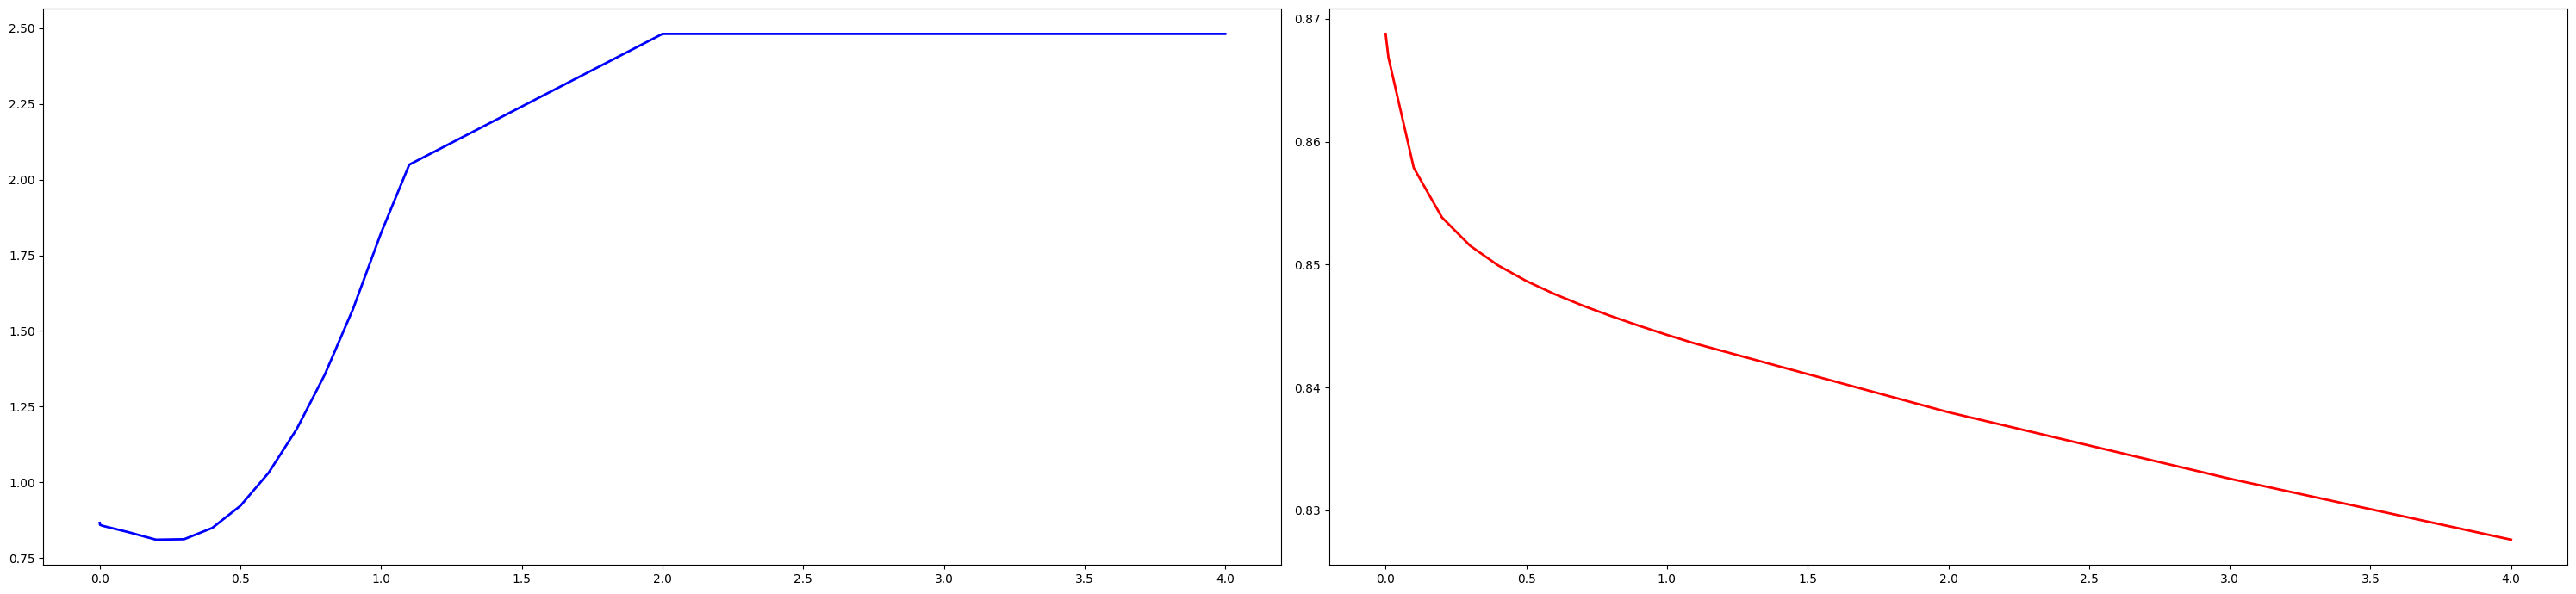

    Alpha  L1_Ratio       MSE
55    0.3      0.01  0.773272
56    0.3      0.10  0.775289
66    0.4      0.01  0.776861
57    0.3      0.20  0.779178
44    0.2      0.01  0.780119


In [255]:
##### LINEAR REGRESSION FITTING USING THE OLS OUTLIER REMOVAL METHOD #####

lr = LinearRegression()

lr.fit(X_train_OLS, Y_train_OLS)
y_pred_OLS = lr.predict(X_val_OLS)

OLS_MSE_LR = mean_squared_error(Y_val_OLS, y_pred_OLS)
OLS_R2_LR = lr.score(X_val_OLS, Y_val_OLS)

print(f"MSE of OLS: {mean_squared_error(Y_val_OLS, y_pred_OLS)}")
print(f"R^2 of OLS: {lr.score(X_val_OLS, Y_val_OLS)}\n")


#### LASSO, RIDGE AND ELASTIC NET REGRESSION USING THE OLS OUTLIER REMOVAL METHOD #####

# Alha values for Lasso and Ridge
alpha = [1e-4, 1e-3, 1e-2,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,2,3,4]

# L1 ratio values for Elastic Net
ratios = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

# Initialize arrays to store the MSE values for Lasso, Ridge and Elastic Net
lasso_mse_array = []
ridge_mse_array = []
en_mse_array = []
en_r2_LR_array = []
lasso_r2_LR_array = []
ridge_r2_LR_array = []

# Loop through the alpha values that calculates the MSE for Lasso and Ridge

for i in range(0,len(alpha)):
    
    lasso = Lasso(alpha=alpha[i],fit_intercept=True,max_iter=100000000, tol=1e-5)
    lasso.fit(X_train_OLS, Y_train_OLS)
    y_pred_lasso = lasso.predict(X_val_OLS)
    lasso_mse_LR = mean_squared_error(Y_val_OLS, y_pred_lasso)
    lasso_mse_array.append([alpha[i], lasso_mse_LR])
    lasso_r2_LR_array.append([alpha[i], lasso.score(X_val_OLS, Y_val_OLS)])
    
    ridge = Ridge(alpha=alpha[i],fit_intercept=True,max_iter=100000000, tol=1e-5)
    ridge.fit(X_train_OLS, Y_train_OLS)
    y_pred_ridge = ridge.predict(X_val_OLS)
    ridge_mse_LR = mean_squared_error(Y_val_OLS, y_pred_ridge)
    ridge_mse_array.append([alpha[i], ridge_mse_LR])
    ridge_r2_LR_array.append([alpha[i], ridge.score(X_val_OLS, Y_val_OLS)])

lasso_mse_array = np.array(lasso_mse_array)
ridge_mse_array = np.array(ridge_mse_array)

print(lasso_r2_LR_array)

# Loop through the alpha and L1 ratio values that calculates the MSE for Elastic Net

for i in alpha:
    for j in ratios:
        en = ElasticNet(alpha=i, l1_ratio=j,fit_intercept=True)
        en.fit(X_train_OLS, Y_train_OLS)
        y_pred_en = en.predict(X_val_OLS)
        en_mse = mean_squared_error(Y_val_OLS, y_pred_en)
        en_mse_array.append([i, j, en_mse])
        en_r2_LR_array.append([i, j, ridge.score(X_val_OLS, Y_val_OLS)])

en_mse_array = np.array(en_mse_array)

# Plot the MSE values for Lasso and Ridge 
fig, axes = plt.subplots(1, 2, figsize=(30, 7))
axes[0].plot(lasso_mse_array[:,0], lasso_mse_array[:,1], color='blue', linewidth=2, label='Lasso')
axes[1].plot(ridge_mse_array[:,0], ridge_mse_array[:,1], color='red', linewidth=2, label='Ridge')
plt.tight_layout() 
plt.show()

# Print the best alpha values for Elastic Net

L1_ratio_results = pd.DataFrame(en_mse_array, columns=['Alpha', 'L1_Ratio', 'MSE']).sort_values(by='MSE')
print(L1_ratio_results.head())

**2 - RANSAC**

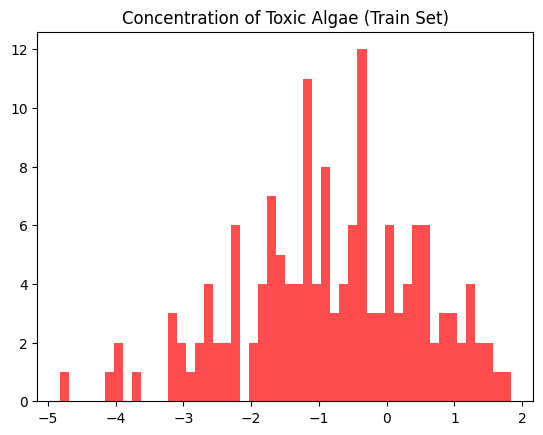

In [256]:
ransac = RANSACRegressor(
    estimator=LinearRegression(), 
    stop_n_inliers= 150, 
    random_state=42
)

ransac.fit(train_data_unfiltered[train_features], train_data_unfiltered['Y_train'])

inlier_mask = ransac.inlier_mask_

train_data_RANSAC = train_data_unfiltered[inlier_mask]
train_data_RANSAC = train_data_RANSAC.reset_index(drop=True)

y_pred_inliers = ransac.predict(train_data_RANSAC[train_features])
residuals_RANSAC_squared = (train_data_RANSAC['Y_train'] - y_pred_inliers)**2

plt.hist(train_data_RANSAC['Y_train'], bins=50, color='red', alpha=0.7)
plt.title('Concentration of Toxic Algae (Train Set)')
plt.show()

# correlation_matrix = train_data_RANSAC.corr()
# plt.figure(figsize=(10, 8))  # Set the figure size
# sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', vmin=-1, vmax=1, center=0)
# plt.title('Correlation Matrix')
# plt.show()
# fig, axes = plt.subplots(1, 5, figsize=(30, 7))

# for i, feature in enumerate(train_features):
#     axes[i].scatter(train_data_RANSAC[feature], train_data_RANSAC['Y_train'], alpha=0.7, color = colours[i])
#     axes[i].set_title(f'{feature} vs  Con. of Toxic Algae (Train Set)')
#     axes[i].set_xlabel(feature)
#     axes[i].set_ylabel('Concentration of Toxic Algae')

# plt.tight_layout() 
# plt.show()

In [257]:
# Data scaling and splitting for the RANSAC method

scaler_RANSAC = StandardScaler()
X_train_RANSAC, X_val_RANSAC, Y_train_RANSAC, Y_val_RANSAC = train_test_split(train_data_RANSAC[train_features],train_data_RANSAC['Y_train'],test_size=0.3, random_state=42)
X_train_RANSAC = scaler_RANSAC.fit_transform(X_train_RANSAC)
X_val_RANSAC = scaler_RANSAC.transform(X_val_RANSAC)

MSE of RANSAC: 0.015519123104318433
R^2 of RANSAC: 0.9902933509875492



/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.206e-01, tolerance: 1.909e-02
  model = cd_fast.enet_coordinate_descent(


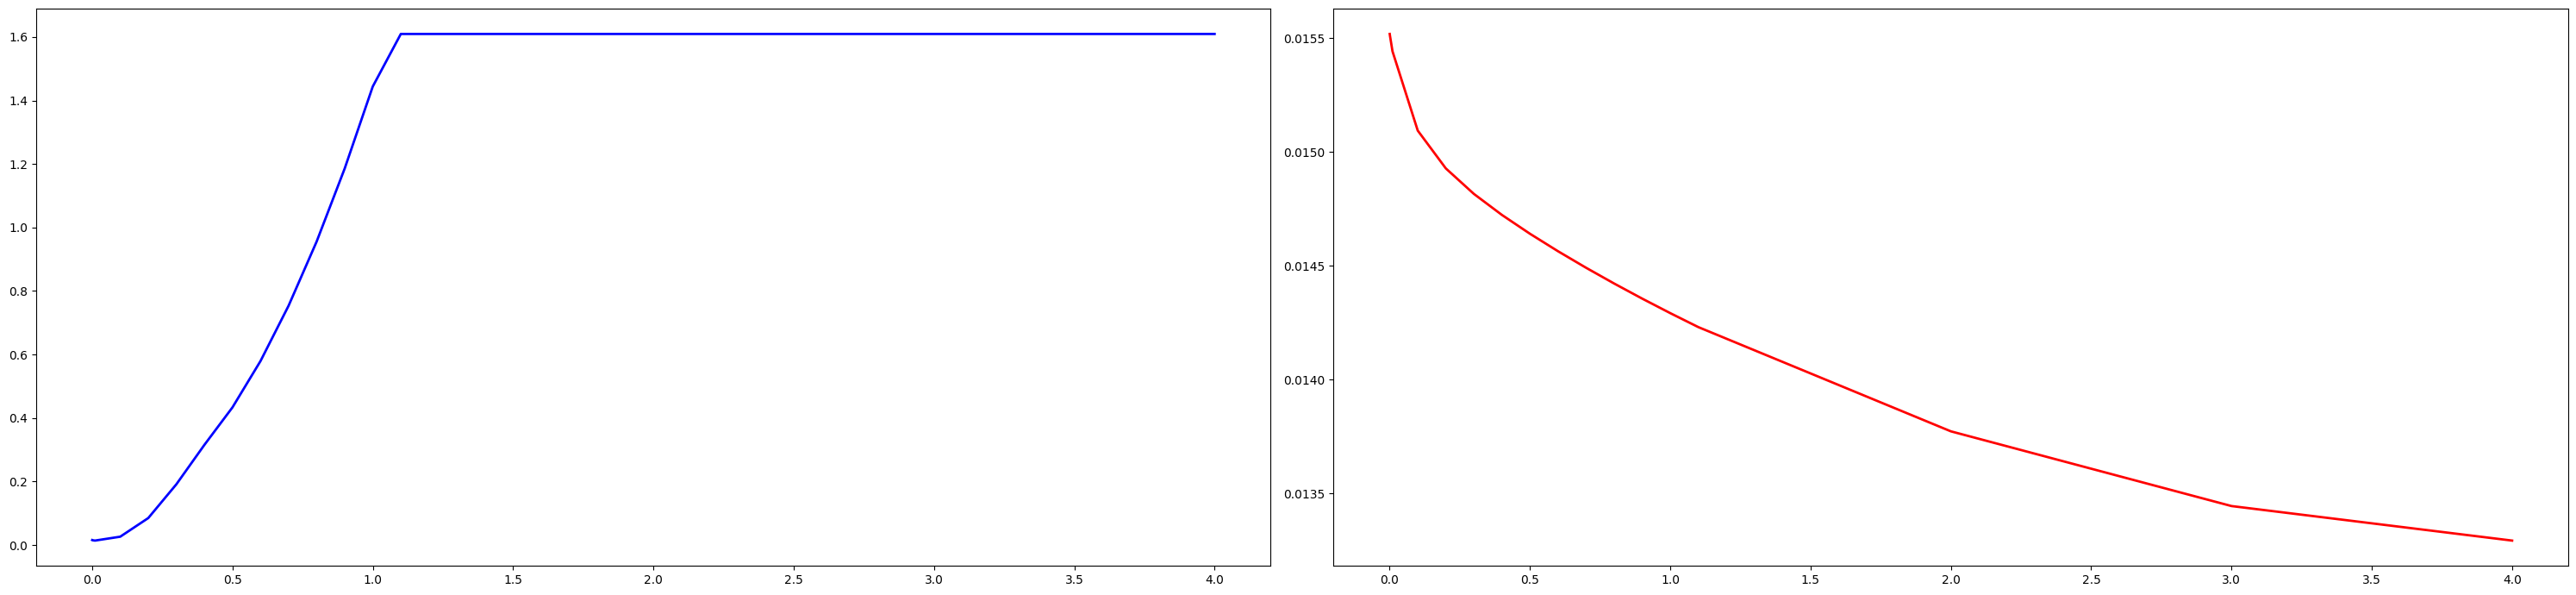

    Alpha  L1_Ratio       MSE
32   0.01       1.0  0.013948
31   0.01       0.9  0.013963
30   0.01       0.8  0.013980
29   0.01       0.7  0.013996
28   0.01       0.6  0.014013


In [258]:
##### LINEAR REGRESSION FITTING USING THE RANSAC OUTLIER REMOVAL METHOD #####

lr = LinearRegression()

lr.fit(X_train_RANSAC, Y_train_RANSAC)
y_pred_RANSAC= lr.predict(X_val_RANSAC)

OLS_mse_RANSAC = mean_squared_error(Y_val_RANSAC, y_pred_RANSAC)
OLS_R2_RANSAC = lr.score(X_val_RANSAC, Y_val_RANSAC)

print(f"MSE of RANSAC: {mean_squared_error(Y_val_RANSAC, y_pred_RANSAC)}")
print(f"R^2 of RANSAC: {lr.score(X_val_RANSAC, Y_val_RANSAC)}\n")

#### LASSO, RIDGE AND ELASTIC NET REGRESSION USING THE RANSAC OUTLIER REMOVAL METHOD #####

# Initialize arrays to store the MSE values for Lasso, Ridge and Elastic Net
lasso_mse_array = []
ridge_mse_array = []
en_mse_array = []
lasso_r2_RANSAC_array = []
ridge_r2_RANSAC_array = []
en_r2_RANSAC_array = []

# Loop through the alpha values that calculates the MSE for Lasso and Ridge

for i in range(0,len(alpha)):
    
    lasso = Lasso(alpha=alpha[i],fit_intercept=True)
    lasso.fit(X_train_RANSAC, Y_train_RANSAC)
    y_pred_lasso = lasso.predict(X_val_RANSAC)
    lasso_mse = mean_squared_error(Y_val_RANSAC, y_pred_lasso)
    lasso_mse_array.append([alpha[i], lasso_mse])
    lasso_mse_RANSAC = lasso.score(X_val_RANSAC, Y_val_RANSAC)
    lasso_r2_RANSAC_array.append([alpha[i], lasso.score(X_val_RANSAC, Y_val_RANSAC)])
    
    ridge = Ridge(alpha=alpha[i],fit_intercept=True)
    ridge.fit(X_train_RANSAC, Y_train_RANSAC)
    y_pred_ridge = ridge.predict(X_val_RANSAC)
    ridge_mse = mean_squared_error(Y_val_RANSAC, y_pred_ridge)
    ridge_mse_array.append([alpha[i], ridge_mse])
    ridge_mse_RANSAC = ridge.score(X_val_RANSAC, Y_val_RANSAC)
    ridge_r2_RANSAC_array.append([alpha[i], lasso.score(X_val_RANSAC, Y_val_RANSAC)])

lasso_mse_array = np.array(lasso_mse_array)
ridge_mse_array = np.array(ridge_mse_array)

# Loop through the alpha and L1 ratio values that calculates the MSE for Elastic Net

for i in alpha:
    for j in ratios:
        en = ElasticNet(alpha=i, l1_ratio=j,fit_intercept=True)
        en.fit(X_train_RANSAC, Y_train_RANSAC)
        y_pred_en = en.predict(X_val_RANSAC)
        en_mse = mean_squared_error(Y_val_RANSAC, y_pred_en)
        en_mse_array.append([i, j, en_mse])
        en_mse_RANSAC = en.score(X_val_RANSAC, Y_val_RANSAC)
        en_r2_RANSAC_array.append([i,j, en.score(X_val_RANSAC, Y_val_RANSAC)])

en_mse_array = np.array(en_mse_array)
fig, axes = plt.subplots(1, 2, figsize=(30, 7))

# Plot the MSE values for Lasso and Ridge 
axes[0].plot(lasso_mse_array[:,0], lasso_mse_array[:,1], color='blue', linewidth=2, label='Lasso')
axes[1].plot(ridge_mse_array[:,0], ridge_mse_array[:,1], color='red', linewidth=2, label='Ridge')
plt.tight_layout() 
plt.show()

# Print the best alpha values for Elastic Net

L1_ratio_results = pd.DataFrame(en_mse_array, columns=['Alpha', 'L1_Ratio', 'MSE']).sort_values(by='MSE')
print(L1_ratio_results.head())

**3 - Huber Regressor**

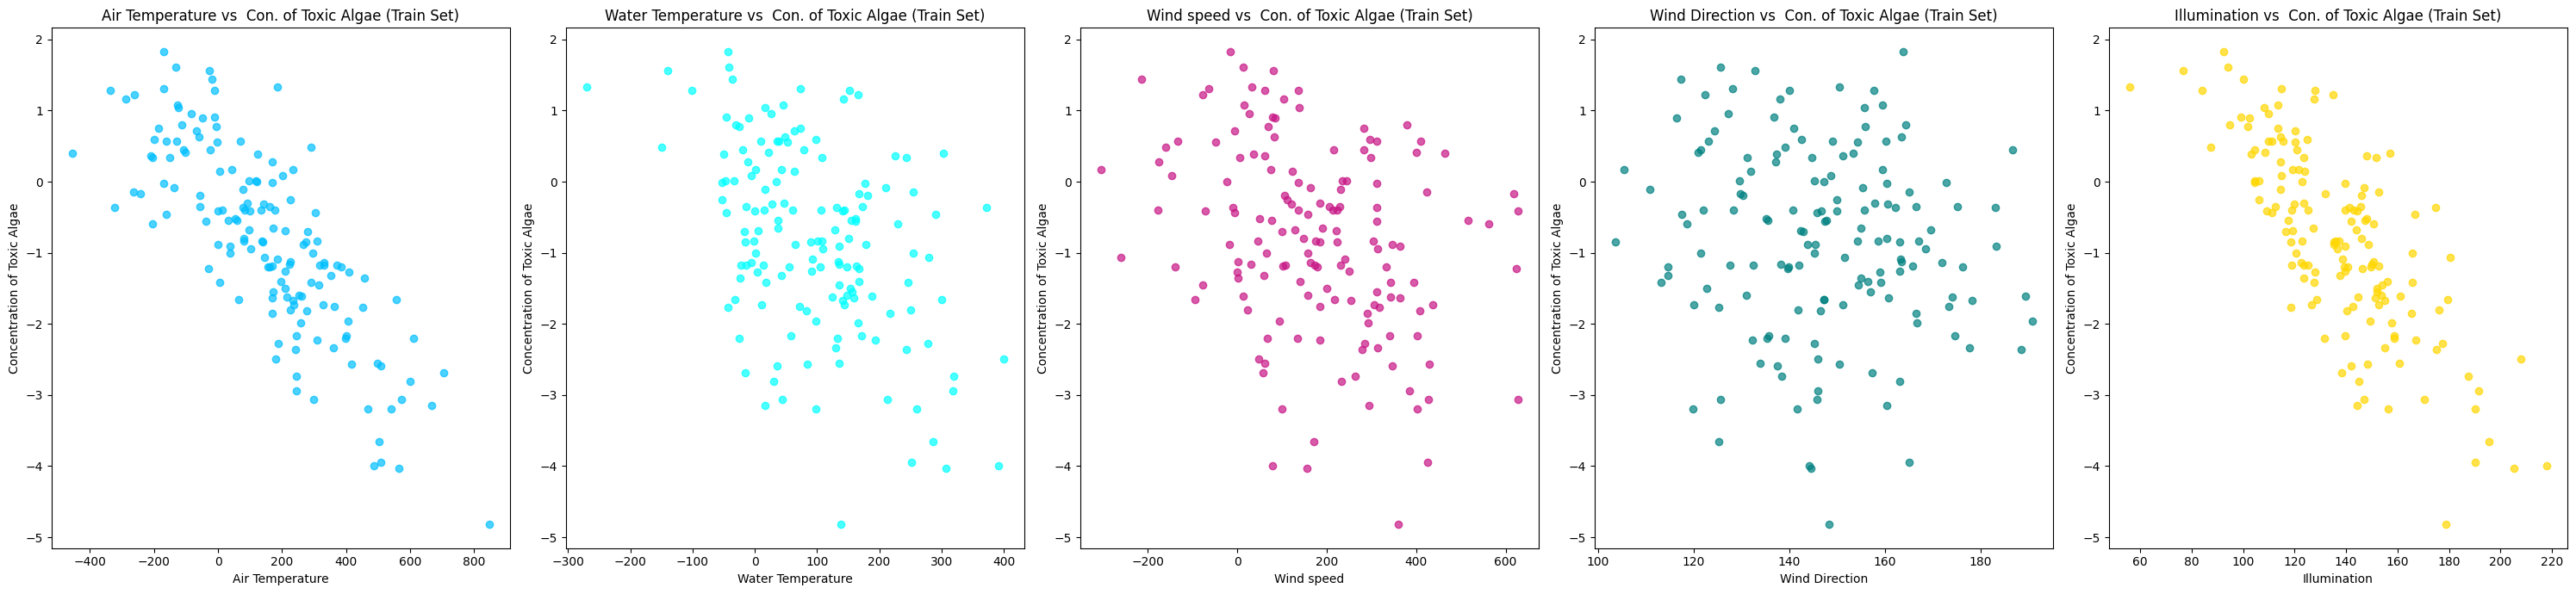

In [259]:
huber_reg = HuberRegressor()

huber_reg.fit(train_data_unfiltered[train_features], train_data_unfiltered['Y_train'])

y_pred_HR = huber_reg.predict(train_data_unfiltered[train_features])

residuals_HR = np.square(train_data_unfiltered['Y_train'] - y_pred_HR)
threshold_HR = np.percentile(residuals_HR, 75)

least_residual_points = train_data_unfiltered[residuals_HR < threshold_HR]

X_train_HR, X_val_HR, Y_train_HR, Y_val_HR = train_test_split(least_residual_points[train_features],least_residual_points['Y_train'],test_size=0.3, random_state=42)

scaler_HR = StandardScaler()

X_train_HR = scaler_HR.fit_transform(X_train_HR)
X_val_HR = scaler_HR.transform(X_val_HR)

fig, axes = plt.subplots(1, 5, figsize=(30, 7))

for i, feature in enumerate(train_features):
    axes[i].scatter(least_residual_points[feature], least_residual_points['Y_train'], alpha=0.7, color = colours[i])
    axes[i].set_title(f'{feature} vs  Con. of Toxic Algae (Train Set)')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Concentration of Toxic Algae')

plt.tight_layout() 
plt.show()

MSE of Huber Regressor: 0.0002490949130704643
R^2 of Huber Regressor: 0.9998690650407152



/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e-02, tolerance: 1.730e-02
  model = cd_fast.enet_coordinate_descent(


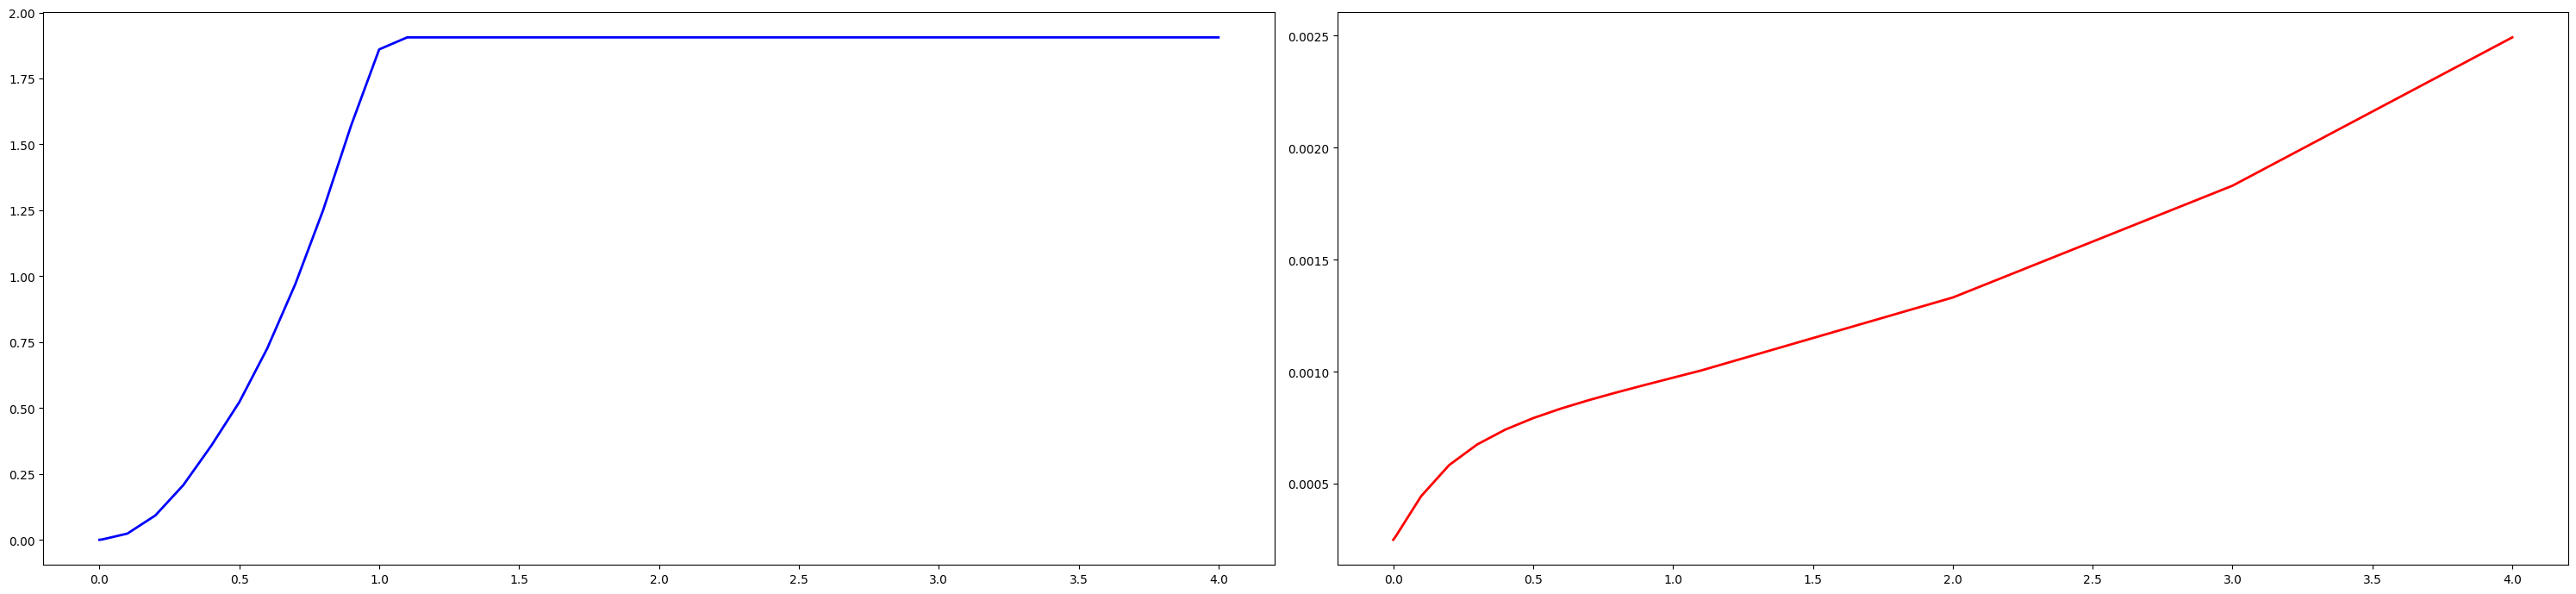

     Alpha  L1_Ratio       MSE
10  0.0001       1.0  0.000238
9   0.0001       0.9  0.000239
8   0.0001       0.8  0.000240
7   0.0001       0.7  0.000240
6   0.0001       0.6  0.000241


In [260]:
lr = LinearRegression()

lr.fit(X_train_HR, Y_train_HR)
y_pred_huber = lr.predict(X_val_HR)

OLS_mse_HR = mean_squared_error(Y_val_HR, y_pred_huber)
OLS_R2_HR = lr.score(X_val_HR, Y_val_HR)

print(f"MSE of Huber Regressor: {mean_squared_error(Y_val_HR, y_pred_huber)}")
print(f"R^2 of Huber Regressor: {lr.score(X_val_HR, Y_val_HR)}\n")

lasso_mse_array = []
ridge_mse_array = []
en_mse_array = []
lasso_r2_HR_array = []
ridge_r2_HR_array = []
en_r2_HR_array = []

for i in range(0,len(alpha)):
    
    lasso = Lasso(alpha=alpha[i],fit_intercept=True)
    lasso.fit(X_train_HR, Y_train_HR)
    y_pred_lasso = lasso.predict(X_val_HR)
    lasso_mse = mean_squared_error(Y_val_HR, y_pred_lasso)
    lasso_mse_array.append([alpha[i], lasso_mse])
    lasso_r2_HR_array.append([alpha[i], lasso.score(X_val_HR, Y_val_HR)])
    
    ridge = Ridge(alpha=alpha[i],fit_intercept=True)
    ridge.fit(X_train_HR, Y_train_HR)
    y_pred_ridge = ridge.predict(X_val_HR)
    ridge_mse = mean_squared_error(Y_val_HR, y_pred_ridge)
    ridge_mse_array.append([alpha[i], ridge_mse])
    ridge_r2_HR_array.append([alpha[i], lasso.score(X_val_HR, Y_val_HR)])

lasso_mse_array = np.array(lasso_mse_array)
ridge_mse_array = np.array(ridge_mse_array)

for i in alpha:
    for j in ratios:
        en = ElasticNet(alpha=i, l1_ratio=j,fit_intercept=True)
        en.fit(X_train_HR, Y_train_HR)
        y_pred_en = en.predict(X_val_HR)
        en_mse = mean_squared_error(Y_val_HR, y_pred_en)
        en_mse_array.append([i, j, en_mse])
        en_r2_HR_array.append([i,j, en.score(X_val_HR, Y_val_HR)])

en_mse_array = np.array(en_mse_array)

fig, axes = plt.subplots(1, 2, figsize=(30, 7))
axes[0].plot(lasso_mse_array[:,0], lasso_mse_array[:,1], color='blue', linewidth=2, label='Lasso')
axes[1].plot(ridge_mse_array[:,0], ridge_mse_array[:,1], color='red', linewidth=2, label='Ridge')
plt.tight_layout() 
plt.show()

L1_ratio_results = pd.DataFrame(en_mse_array, columns=['Alpha', 'L1_Ratio', 'MSE']).sort_values(by='MSE')
print(L1_ratio_results.head())

**4 - Theil–Sen estimator**

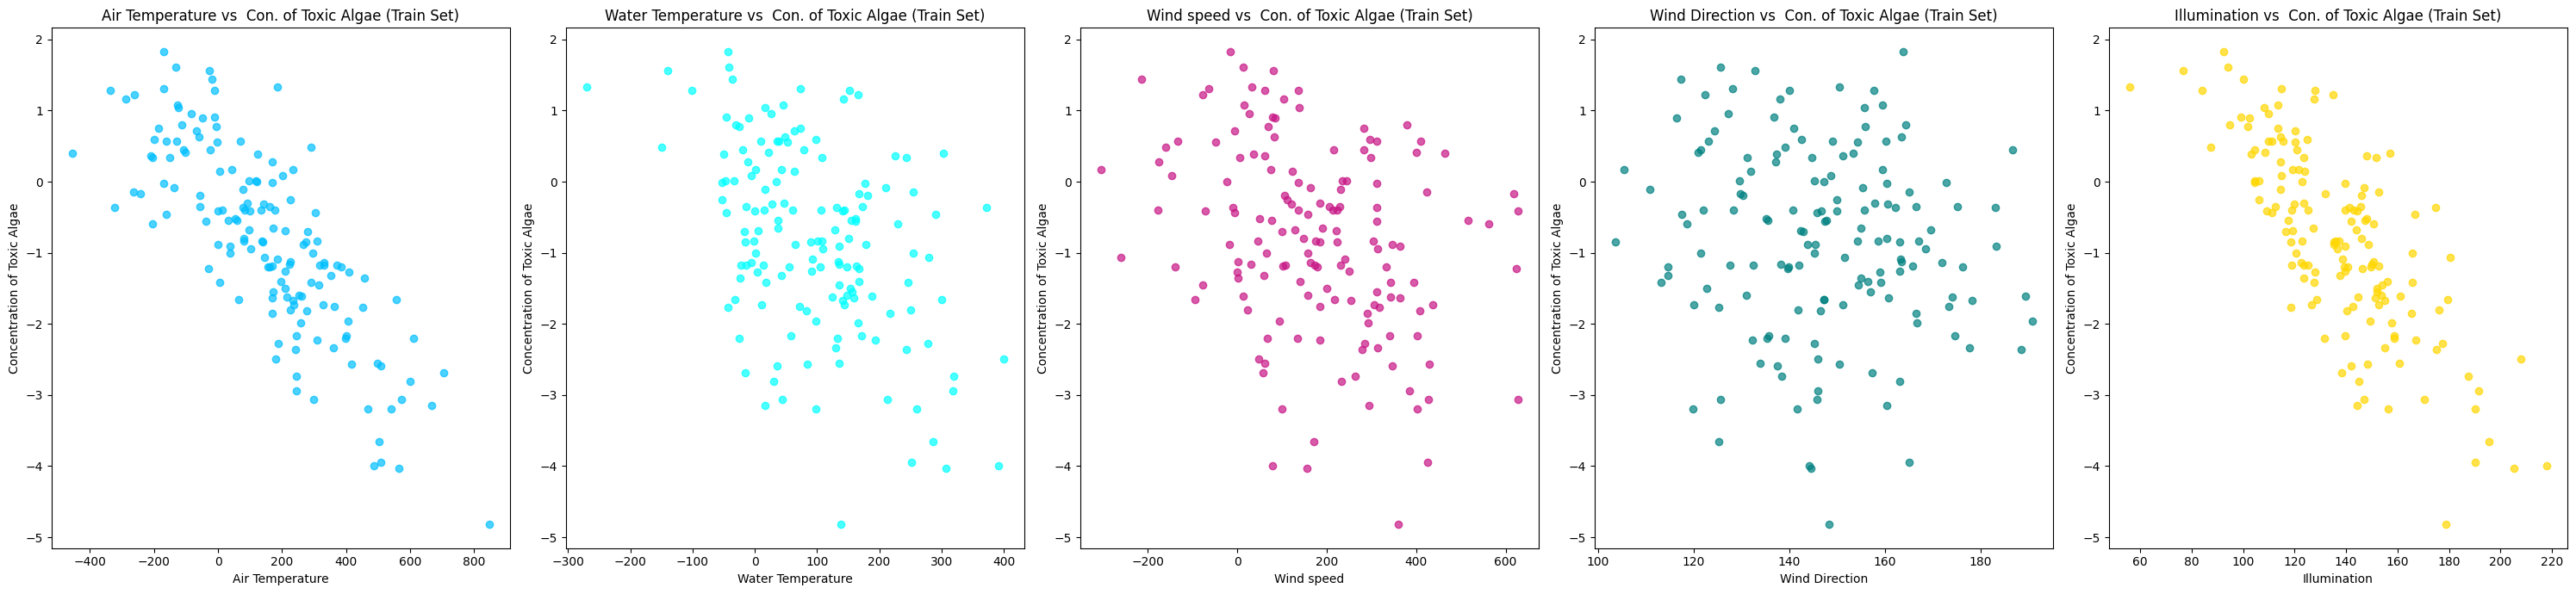

In [261]:
TheilSen = TheilSenRegressor(random_state=42)

TheilSen.fit(train_data_unfiltered[train_features], train_data_unfiltered['Y_train'])
y_pred_TS = TheilSen.predict(train_data_unfiltered[train_features])

residuals_TS = np.square(train_data_unfiltered['Y_train'] - y_pred_TS)
threshold_TS = np.percentile(residuals_TS, 75)

least_residual_TS = train_data_unfiltered[residuals_TS < threshold_TS]

X_train_TS, X_val_TS, Y_train_TS, Y_val_TS = train_test_split(least_residual_TS[train_features],least_residual_TS['Y_train'],test_size=0.3, random_state=42)

scaler_TS = StandardScaler()

X_train_TS = scaler_TS.fit_transform(X_train_TS)
X_val_TS = scaler_HR.transform(X_val_TS)

fig, axes = plt.subplots(1, 5, figsize=(30, 7))

for i, feature in enumerate(train_features):
    axes[i].scatter(least_residual_TS[feature], least_residual_TS['Y_train'], alpha=0.7, color = colours[i])
    axes[i].set_title(f'{feature} vs  Con. of Toxic Algae (Train Set)')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Concentration of Toxic Algae')

plt.tight_layout() 
plt.show()

MSE of Theil Sen: 0.0002490949130704643
R^2 of Theil Sen: 0.9998690650407152
 


/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e-02, tolerance: 1.730e-02
  model = cd_fast.enet_coordinate_descent(


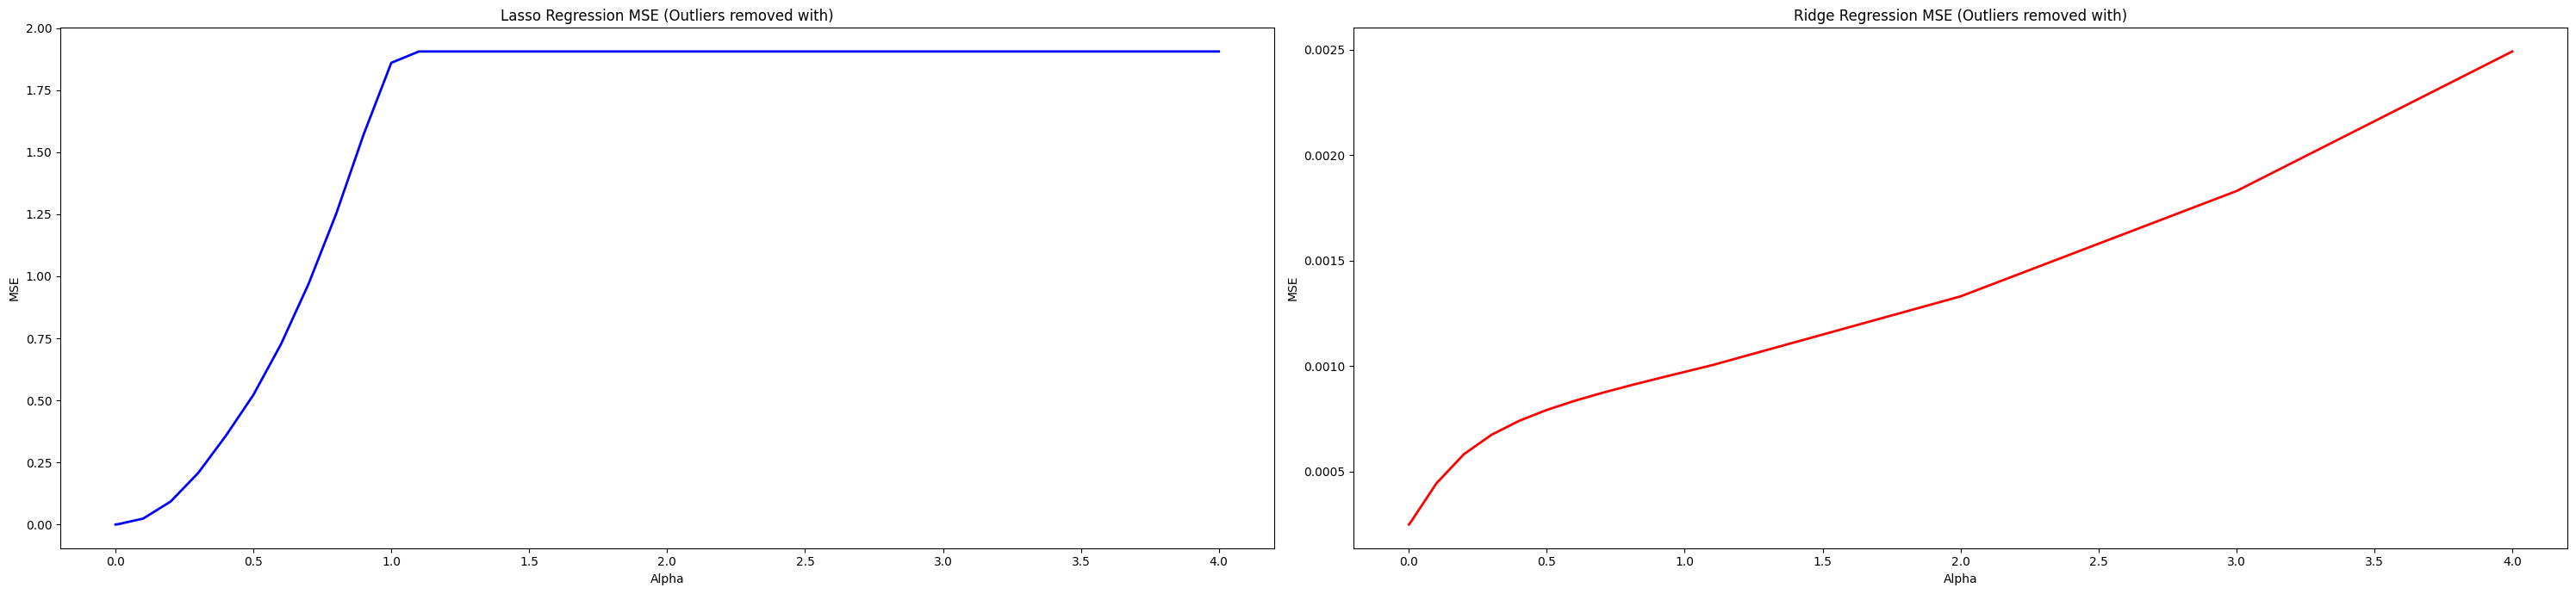

     Alpha  L1_Ratio       MSE
10  0.0001       1.0  0.000238
9   0.0001       0.9  0.000239
8   0.0001       0.8  0.000240
7   0.0001       0.7  0.000240
6   0.0001       0.6  0.000241


In [280]:
lr = LinearRegression()

lr.fit(X_train_TS, Y_train_TS)
y_pred_TS = lr.predict(X_val_TS)

OLS_r2_TS = lr.score(X_val_TS, Y_val_TS)

print(f"MSE of Theil Sen: {mean_squared_error(Y_val_TS, y_pred_TS)}")
print(f"R^2 of Theil Sen: {lr.score(X_val_TS, Y_val_TS)}\n ")

lasso_mse_array = []
ridge_mse_array = []
en_mse_array = []
lasso_r2_TS_array = []
ridge_r2_TS_array = []
en_r2_TS_array = []

for i in range(0,len(alpha)):
    lasso = Lasso(alpha=alpha[i],fit_intercept=True)
    lasso.fit(X_train_TS, Y_train_TS)
    y_pred_lasso = lasso.predict(X_val_TS)
    lasso_mse = mean_squared_error(Y_val_TS, y_pred_lasso)
    lasso_mse_array.append([alpha[i], lasso_mse])
    #print(mean_squared_error(Y_val_TS, y_pred_lasso))
    lasso_r2_TS_array.append([alpha[i], lasso.score(X_val_TS, Y_val_TS)])
    
    ridge = Ridge(alpha=alpha[i],fit_intercept=True)
    ridge.fit(X_train_TS, Y_train_TS)
    y_pred_ridge = ridge.predict(X_val_TS)
    ridge_mse = mean_squared_error(Y_val_TS, y_pred_ridge)
    ridge_mse_array.append([alpha[i], ridge_mse])
    ridge_r2_TS = ridge.score(X_val_TS, Y_val_TS)
    ridge_r2_TS_array.append([alpha[i], ridge.score(X_val_TS, Y_val_TS)])

lasso_mse_array = np.array(lasso_mse_array)
ridge_mse_array = np.array(ridge_mse_array)

for i in alpha:
    for j in ratios:
        en = ElasticNet(alpha=i, l1_ratio=j)
        en.fit(X_train_TS, Y_train_TS)
        y_pred_en = en.predict(X_val_TS)
        en_mse = mean_squared_error(Y_val_TS, y_pred_en)
        en_mse_array.append([i, j, en_mse])
        en_r2_TS = en.score(X_val_TS, Y_val_TS)
        en_r2_TS_array.append([i,j, en.score(X_val_TS, Y_val_TS)])

en_mse_array = np.array(en_mse_array)

fig, axes = plt.subplots(1, 2, figsize=(30, 7))
axes[0].plot(lasso_mse_array[:,0], lasso_mse_array[:,1], color='blue', linewidth=2, label='Lasso')
axes[0].set_title('Lasso Regression MSE (Outliers removed with)')
axes[0].set_xlabel('Alpha')                
axes[0].set_ylabel('MSE')                  
axes[1].plot(ridge_mse_array[:,0], ridge_mse_array[:,1], color='red', linewidth=2, label='Ridge')
axes[1].set_title('Ridge Regression MSE (Outliers removed with)') 
axes[1].set_xlabel('Alpha')               
axes[1].set_ylabel('MSE')                  
plt.tight_layout() 
plt.show()

L1_ratio_results = pd.DataFrame(en_mse_array, columns=['Alpha', 'L1_Ratio', 'MSE']).sort_values(by='MSE')
print(L1_ratio_results.head())

In [263]:
print("Huber Regressor: {:.2e}\n"
      "Ordinary Least Squares: {:.2e}\n"
      "Theil Sen Regressor: {:.2e}\n"
      "RANSAC: {:.2e}".format(
          residuals_HR[residuals_HR < threshold_HR].mean(),
          residuals_OLS[residuals_OLS < threshold_OLS].mean(),
          residuals_TS[residuals_TS < threshold_TS].mean(),
          np.mean(residuals_RANSAC_squared)
      ))



Huber Regressor: 5.91e-04
Ordinary Least Squares: 5.94e+00
Theil Sen Regressor: 1.59e-03
RANSAC: 7.49e-03


**Cross-validation**

We are trying all the regressions with cross validation using the several outlier removal methods except for the linear regressiion because it is the least robust method

RidgeCV (outliers with RANSAC)

In [264]:
# Initialize the RidgeCV model with the list of alpha values
ridge_cv_model = RidgeCV(alphas=alpha, store_cv_results=True)

# CV automatically divides the data so the variables to the fit should be the whole dataset

CV_scaler_x = StandardScaler()
CV_scaler_y = StandardScaler()

x_train_ridgeCV_RANSAC = CV_scaler_x.fit_transform(train_data_RANSAC[train_features])
y_train_ridgeCV_RANSAC = train_data_RANSAC['Y_train'].values.reshape(-1, 1)
y_train_scaled_ridgeCV_RANSAC = CV_scaler_y.fit_transform(y_train_ridgeCV_RANSAC)

# Fit the model to the training data
ridge_cv_model.fit(x_train_ridgeCV_RANSAC, y_train_scaled_ridgeCV_RANSAC.ravel())

y_pred_scaled_rcv_ransac= ridge_cv_model.predict(x_train_ridgeCV_RANSAC)

# Inverse transform predictions back to the original scale of y
y_pred_rcv_ransac = CV_scaler_y.inverse_transform(y_pred_scaled_rcv_ransac.reshape(-1, 1))

# Access the best alpha value chosen during cross-validation
best_alpha = ridge_cv_model.alpha_
best_ridge_cv = RidgeCV(best_alpha)
print(f"Best alpha: {best_alpha}")

# Access the cross-validation values (mean squared error for each fold and alpha)
cv_values = ridge_cv_model.cv_results_
cv_df = pd.DataFrame(cv_values, columns=[f'Alpha: {alpha}' for alpha in alpha])

# Display the cross-validation values
print("\nCross-Validation MSE for each alpha and fold:")
print(cv_df.head())



# Perform cross-validation and calculate the average R^2 score across folds
ridge_cv_RANSAC_r2_scores = cross_val_score(best_ridge_cv, x_train_ridgeCV_RANSAC, y_train_scaled_ridgeCV_RANSAC, cv=5, scoring='r2')
print(f"\nCross-Validated R^2 Scores: {ridge_cv_RANSAC_r2_scores}")
ridge_cv_RANSAC_r2_scores_mean = cross_val_score(best_ridge_cv, x_train_ridgeCV_RANSAC, y_train_scaled_ridgeCV_RANSAC, cv=5, scoring='r2').mean()
print(f"Mean R^2 Score: {ridge_cv_RANSAC_r2_scores_mean}")

Best alpha: 0.01

Cross-Validation MSE for each alpha and fold:
   Alpha: 0.0001  Alpha: 0.001  Alpha: 0.01  Alpha: 0.1  Alpha: 0.2  \
0       0.002303      0.002324     0.002524    0.003969    0.004892   
1       0.000147      0.000148     0.000157    0.000214    0.000248   
2       0.000118      0.000118     0.000118    0.000122    0.000126   
3       0.000689      0.000691     0.000709    0.000823    0.000878   
4       0.000004      0.000004     0.000004    0.000003    0.000001   

     Alpha: 0.3    Alpha: 0.4    Alpha: 0.5    Alpha: 0.6  Alpha: 0.7  \
0  5.485859e-03  5.911014e-03  6.238821e-03  6.505609e-03    0.006732   
1  2.681454e-04  2.806568e-04  2.889299e-04  2.945384e-04    0.000298   
2  1.289817e-04  1.319107e-04  1.347499e-04  1.375416e-04    0.000140   
3  9.027668e-04  9.117576e-04  9.121128e-04  9.071856e-04    0.000899   
4  4.863741e-07  4.689298e-08  7.103030e-08  5.634778e-07    0.000002   

   Alpha: 0.8  Alpha: 0.9  Alpha: 1  Alpha: 1.1  Alpha: 2  Alpha: 3  A

LassoCV (outliers with RANSAC)

In [265]:
# Initialize the LassoCV model with the list of alpha values
lasso_cv_model = LassoCV(alphas=alpha)

# CV automatically divides the data so the variables to the fit should be the whole dataset

x_train_lassoCV_ransac= CV_scaler_x.fit_transform(train_data_RANSAC[train_features])
y_train_lasso_ransac = train_data_RANSAC['Y_train'].values.reshape(-1, 1)
y_train_lasso_scaled_ransac = CV_scaler_y.fit_transform(y_train_lasso_ransac)

# Fit the model to the training data
lasso_cv_model.fit(x_train_lassoCV_ransac, y_train_lasso_scaled_ransac.ravel())

y_pred_scaled_lassocv_ransac = lasso_cv_model.predict(x_train_lassoCV_ransac)

# Inverse transform predictions back to the original scale of y
y_pred_lassocv_ransac = CV_scaler_y.inverse_transform(y_pred_scaled_lassocv_ransac.reshape(-1, 1))

# Access the best alpha value chosen during cross-validation
best_alpha = lasso_cv_model.alpha_
print(f"Best alpha: {best_alpha}")

best_lasso_cv = LassoCV(alphas=[best_alpha])

# Access the cross-validation values (mean squared error for each fold and alpha)
cv_values_lasso = lasso_cv_model.mse_path_
cv_df = pd.DataFrame(cv_values_lasso, columns=[f'Fold {i+1}' for i in range(cv_values_lasso.shape[1])])

# Display the cross-validation values
print("\nCross-Validation MSE for each fold and alpha:")
print(cv_df.head())

# Perform cross-validation and calculate the average R^2 score across folds
lasso_cv_RANSAC_r2_scores = cross_val_score(best_lasso_cv, x_train_lassoCV_ransac, y_train_lasso_scaled_ransac, cv=5, scoring='r2')
print(f"\nCross-Validated R^2 Scores: {lasso_cv_RANSAC_r2_scores}")
lasso_cv_RANSAC_r2_scores_mean = cross_val_score(best_lasso_cv, x_train_lassoCV_ransac, y_train_lasso_scaled_ransac, cv=5, scoring='r2').mean()
print(f"Mean R^2 Score: {lasso_cv_RANSAC_r2_scores_mean}")

Best alpha: 0.0001

Cross-Validation MSE for each fold and alpha:
     Fold 1    Fold 2    Fold 3    Fold 4    Fold 5
0  0.874359  1.053402  1.124894  1.060137  0.938528
1  0.874359  1.053402  1.124894  1.060137  0.938528
2  0.874359  1.053402  1.124894  1.060137  0.938528
3  0.874359  1.053402  1.124894  1.060137  0.938528
4  0.874359  1.053402  1.124894  1.060137  0.938528

Cross-Validated R^2 Scores: [0.9852767  0.99936939 0.99972814 0.99967428 0.99026047]
Mean R^2 Score: 0.9948617976999626


/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025073958077594383, tolerance: 0.011971993853181753
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03602218046581973, tolerance: 0.011857930967314476
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02012279242662912, tolerance: 0.012019903974307048
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_de

ElasticNetCV (outliers with RANSAC)

In [266]:
from sklearn.linear_model import ElasticNet
# Initialize the ElasticNetCV model with the list of alpha values and l1_ratio values
elasticnet_cv_model = ElasticNetCV(alphas=alpha, l1_ratio=ratios, cv=5, n_jobs=-1)

x_train_elasticnetCV_ransac = CV_scaler_x.fit_transform(train_data_RANSAC[train_features])
y_train_elasticnet_ransac = train_data_RANSAC['Y_train'].values.reshape(-1, 1)
y_train_elasticnet_scaled_ransac = CV_scaler_y.fit_transform(y_train_elasticnet_ransac)

# Fit the model to the training data
elasticnet_cv_model.fit(x_train_elasticnetCV_ransac, y_train_elasticnet_scaled_ransac.ravel())

# Predict using the fitted model
y_pred_scaled_elasticnet_ransac = elasticnet_cv_model.predict(x_train_elasticnetCV_ransac)
y_pred_elasticnet_ransac = CV_scaler_y.inverse_transform(y_pred_scaled_elasticnet_ransac.reshape(-1, 1))

# Access the best alpha and l1_ratio values chosen during cross-validation
best_alpha = elasticnet_cv_model.alpha_
best_l1_ratio = elasticnet_cv_model.l1_ratio_
best_en_cv = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, random_state=42)


print(f"Best alpha: {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")
best_en_cv_ransac = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, random_state=42)

# Access the cross-validation values (mean squared error for each fold, alpha, and l1_ratio)
cv_values_elasticnet = elasticnet_cv_model.mse_path_
cv_values_elasticnet_reshaped = cv_values_elasticnet.reshape(cv_values_elasticnet.shape[0] * cv_values_elasticnet.shape[1], cv_values_elasticnet.shape[2])
cv_df = pd.DataFrame(cv_values_elasticnet_reshaped, columns=[f'Fold {i+1}' for i in range(cv_values_elasticnet_reshaped.shape[1])])

# Display the cross-validation values
print("\nCross-Validation MSE for each fold, alpha, and l1_ratio:")
print(cv_df.head())

# Perform cross-validation and calculate the average R^2 score across folds for the best alpha and l1_ratio values

elasticnet_cv_RANSAC_r2_scores = cross_val_score(best_en_cv_ransac, x_train_elasticnetCV_ransac, y_train_elasticnet_scaled_ransac, cv=5, scoring='r2')
print(f"\nCross-Validated R^2 Scores: {elasticnet_cv_RANSAC_r2_scores}")
elasticnet_cv_RANSAC_r2_scores_mean = cross_val_score(best_en_cv_ransac, x_train_elasticnetCV_ransac, y_train_elasticnet_scaled_ransac, cv=5, scoring='r2').mean()
print(f"Mean R^2 Score: {elasticnet_cv_RANSAC_r2_scores_mean}")


Best alpha: 0.0001
Best l1_ratio: 0.01

Cross-Validation MSE for each fold, alpha, and l1_ratio:
     Fold 1    Fold 2    Fold 3    Fold 4    Fold 5
0  0.453401  0.577174  0.635291  0.665962  0.521360
1  0.376221  0.486681  0.538913  0.584149  0.442781
2  0.271553  0.361547  0.403784  0.464187  0.334333
3  0.145519  0.205079  0.230839  0.295609  0.198155
4  0.129723  0.184740  0.207954  0.271341  0.180290

Cross-Validated R^2 Scores: [0.9853427  0.99934873 0.9997283  0.99966992 0.9902549 ]
Mean R^2 Score: 0.9948689109979394


/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03183230799798792, tolerance: 0.01249461873755348
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04223118546259147, tolerance: 0.012019903974307048
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13132722520316792, tolerance: 0.01249461873755348
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_desce

OLS CV with RANSAC

In [267]:
from sklearn.metrics import r2_score
# Creating different folds

kf = KFold(n_splits = 5, shuffle = True)


#Defining the OLS model

kf_ols = LinearRegression()
ols_5fold_RANSAC = []

x_train_OLS_CV_ransac = CV_scaler_x.fit_transform(train_data_RANSAC[train_features])
y_train_OLS_CV_ransac = train_data_RANSAC['Y_train'].values.reshape(-1, 1)
y_train_OLS_scaled_ransac = CV_scaler_y.fit_transform(y_train_OLS_CV_ransac)

# Defining the hyperparameter space

param_kf_ols = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Using randomized search
for i in range(100):
    ols_grid_search = GridSearchCV(kf_ols, param_kf_ols, 
        cv= kf,
        scoring=make_scorer(mean_squared_error, greater_is_better=False), 
        return_train_score = True)
    ols_grid_search.fit(x_train_OLS_CV_ransac, y_train_OLS_CV_ransac)
    ols_5fold_RANSAC = pd.DataFrame(ols_grid_search.cv_results_)
    ols_5fold_RANSAC = ols_5fold_RANSAC[[i for i in ols_5fold_RANSAC.columns if 'split' not in i and 'time' not in i and 'std' not in i and 'params' not in i]].sort_values(by='rank_test_score')
    ols_5fold_RANSAC = pd.concat([ols_5fold_RANSAC, ols_5fold_RANSAC])

OLS_cv_RANSAC_r2_scores = r2_score(y_train_OLS_CV_ransac, ols_grid_search.predict(x_train_OLS_CV_ransac))
#OLS_cv_RANSAC_r2_scores_mean = r2_score(y_train_OLS_CV_ransac, ols_grid_search.predict(x_train_OLS_CV_ransac)).mean()

print(f"\nCross-Validated R^2 Scores: {r2_score(y_train_OLS_CV_ransac, ols_grid_search.predict(x_train_OLS_CV_ransac))}\n")
#print(f"Mean R^2 Score: {r2_score(y_train_OLS_CV_ransac, ols_grid_search.predict(x_train_OLS_CV_ransac)).mean()}")

# Display the concatenated DataFrame
ols_5fold_RANSAC


Cross-Validated R^2 Scores: 0.9957014910317193



,param_fit_intercept,param_positive,mean_test_score,rank_test_score,mean_train_score
1,True,False,-0.008203,1,-0.007426
3,False,False,-0.759010,2,-0.692981
0,True,True,-1.754292,3,-1.739881
2,False,True,-2.429398,4,-2.434012
1,True,False,-0.008203,1,-0.007426
3,False,False,-0.759010,2,-0.692981
0,True,True,-1.754292,3,-1.739881
2,False,True,-2.429398,4,-2.434012


RidgeCV with Huber

In [268]:
# Initialize the RidgeCV model with the list of alpha values
ridge_cv_model = RidgeCV(alphas=alpha, store_cv_results=True)

# CV automatically divides the data so the variables to the fit should be the whole dataset

CV_scaler_x = StandardScaler()
CV_scaler_y = StandardScaler()

x_train_ridgeCV = CV_scaler_x.fit_transform(least_residual_points[train_features])
y_train = least_residual_points['Y_train'].values.reshape(-1, 1)
y_train_scaled = CV_scaler_y.fit_transform(y_train)

# Fit the model to the training data
ridge_cv_model.fit(x_train_ridgeCV, y_train_scaled.ravel())

y_pred_scaled = ridge_cv_model.predict(x_train_ridgeCV)

# Inverse transform predictions back to the original scale of y
y_pred = CV_scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Access the best alpha value chosen during cross-validation
best_alpha = ridge_cv_model.alpha_
best_ridge_cv_HR = RidgeCV(best_alpha, store_cv_results = True)  # Fix: Use Ridge instead of RidgeCV
print(f"Best alpha: {best_alpha}")

# Access the cross-validation values (mean squared error for each fold and alpha)
cv_values = ridge_cv_model.cv_results_
cv_df = pd.DataFrame(cv_values, columns=[f'Alpha: {alpha}' for alpha in alpha])

# Display the cross-validation values
print("\nCross-Validation MSE for each alpha and fold:")
print(cv_df.head())



# Perform cross-validation and calculate the average R^2 score across folds
Ridge_cv_r2_scores_Huber = cross_val_score(best_ridge_cv_HR, x_train_ridgeCV, y_train_scaled, cv=5, scoring='r2')
Ridge_cv_r2_scores_Huber_mean = cross_val_score(best_ridge_cv_HR, x_train_ridgeCV, y_train_scaled, cv=5, scoring='r2').mean()
print(f"\nCross-Validated R^2 Scores: {Ridge_cv_r2_scores_Huber}")
print(f"Mean R^2 Score: {Ridge_cv_r2_scores_Huber_mean}")

Best alpha: 0.001

Cross-Validation MSE for each alpha and fold:
   Alpha: 0.0001  Alpha: 0.001  Alpha: 0.01  Alpha: 0.1  Alpha: 0.2  \
0       0.000009      0.000011     0.000044    0.000723    0.001425   
1       0.000076      0.000075     0.000067    0.000024    0.000010   
2       0.000016      0.000016     0.000016    0.000019    0.000020   
3       0.000988      0.000991     0.001022    0.001226    0.001331   
4       0.000012      0.000012     0.000012    0.000009    0.000006   

   Alpha: 0.3  Alpha: 0.4  Alpha: 0.5    Alpha: 0.6    Alpha: 0.7  \
0    0.001944    0.002336    0.002646  2.900568e-03  3.116451e-03   
1    0.000005    0.000003    0.000001  8.150096e-07  4.750677e-07   
2    0.000022    0.000023    0.000025  2.580894e-05  2.709297e-05   
3    0.001383    0.001408    0.001418  1.418747e-03  1.413396e-03   
4    0.000004    0.000002    0.000001  2.814368e-07  1.128759e-09   

     Alpha: 0.8    Alpha: 0.9      Alpha: 1    Alpha: 1.1      Alpha: 2  \
0  3.304508e-03  3

2 - Lasso Cross Validation (outliers with Huber Regressor)

In [269]:
# Initialize the LassoCV model with the list of alpha values
lasso_cv_model = LassoCV(alphas=alpha)

# CV automatically divides the data so the variables to the fit should be the whole dataset

x_train_lassoCV = CV_scaler_x.fit_transform(least_residual_points[train_features])
y_train_lasso = least_residual_points['Y_train'].values.reshape(-1, 1)
y_train_lasso_scaled = CV_scaler_y.fit_transform(y_train_lasso)

# Fit the model to the training data
lasso_cv_model.fit(x_train_lassoCV, y_train_lasso_scaled.ravel())

y_pred_scaled_lasso = lasso_cv_model.predict(x_train_lassoCV)

# Inverse transform predictions back to the original scale of y
y_pred_lasso = CV_scaler_y.inverse_transform(y_pred_scaled_lasso.reshape(-1, 1))

# Access the best alpha value chosen during cross-validation
best_alpha = lasso_cv_model.alpha_
best_lasso_cv_Huber = LassoCV(alphas=best_alpha)
print(f"Best alpha: {best_alpha}")

# Access the cross-validation values (mean squared error for each fold and alpha)
cv_values_lasso = lasso_cv_model.mse_path_
cv_df = pd.DataFrame(cv_values_lasso, columns=[f'Fold {i+1}' for i in range(cv_values_lasso.shape[1])])

# Display the cross-validation values
print("\nCross-Validation MSE for each fold and alpha:")
print(cv_df.head())

# Perform cross-validation and calculate the average R^2 score across folds
lasso_cv_Huber_r2_scores = cross_val_score(LassoCV(alphas = [best_alpha]), x_train_lassoCV, y_train_lasso_scaled, cv=5, scoring='r2')
lasso_cv_Huber_r2_scores_mean = cross_val_score(LassoCV(alphas = [best_alpha]), x_train_lassoCV, y_train_lasso_scaled, cv=5, scoring='r2').mean()
print(f"\nCross-Validated R^2 Scores: {lasso_cv_Huber_r2_scores}")
print(f"Mean R^2 Score: {lasso_cv_Huber_r2_scores_mean}")

Best alpha: 0.0001

Cross-Validation MSE for each fold and alpha:
     Fold 1    Fold 2    Fold 3    Fold 4   Fold 5
0  0.850891  1.087595  1.140126  1.058145  0.90218
1  0.850891  1.087595  1.140126  1.058145  0.90218
2  0.850891  1.087595  1.140126  1.058145  0.90218
3  0.850891  1.087595  1.140126  1.058145  0.90218
4  0.850891  1.087595  1.140126  1.058145  0.90218

Cross-Validated R^2 Scores: [0.99983644 0.99985954 0.9998187  0.99989242 0.99980226]
Mean R^2 Score: 0.9998418707614996


/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d

Elastic Net with Cross Validation (Huber)

In [270]:
# Initialize the ElasticNetCV model with the list of alpha values and l1_ratio values
elasticnet_cv_model = ElasticNetCV(alphas=alpha, l1_ratio=ratios, cv=5, n_jobs=-1)

x_train_elasticnetCV = CV_scaler_x.fit_transform(least_residual_points[train_features])
y_train_elasticnet = least_residual_points['Y_train'].values.reshape(-1, 1)
y_train_elasticnet_scaled = CV_scaler_y.fit_transform(y_train_elasticnet)

# Fit the model to the training data
elasticnet_cv_model.fit(x_train_elasticnetCV, y_train_elasticnet_scaled.ravel())

# Predict using the fitted model
y_pred_scaled_elasticnet = elasticnet_cv_model.predict(x_train_elasticnetCV)

# Inverse transform predictions back to the original scale of y
y_pred_elasticnet = CV_scaler_y.inverse_transform(y_pred_scaled_elasticnet.reshape(-1, 1))

# Access the best alpha and l1_ratio values chosen during cross-validation
best_alpha = elasticnet_cv_model.alpha_
best_l1_ratio = elasticnet_cv_model.l1_ratio_
best_en_cv_Huber = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, random_state=42)
print(f"Best alpha: {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")

# Access the cross-validation values (mean squared error for each fold, alpha, and l1_ratio)
cv_values_elasticnet = elasticnet_cv_model.mse_path_
cv_values_elasticnet_reshaped = cv_values_elasticnet.reshape(cv_values_elasticnet.shape[0] * cv_values_elasticnet.shape[1], cv_values_elasticnet.shape[2])
cv_df = pd.DataFrame(cv_values_elasticnet_reshaped, columns=[f'Fold {i+1}' for i in range(cv_values_elasticnet_reshaped.shape[1])])

# Display the cross-validation values
print("\nCross-Validation MSE for each fold, alpha, and l1_ratio:")
print(cv_df.head())

en_cv_huber_r2_scores = cross_val_score(best_en_cv_Huber, x_train_elasticnetCV, y_train_elasticnet_scaled, cv=5, scoring='r2')
print(f"\nCross-Validated R^2 Scores: {en_cv_huber_r2_scores}")

# Perform cross-validation and calculate the average R^2 score across folds
en_cv_huber_r2_scores_mean = cross_val_score(best_en_cv_Huber, x_train_elasticnetCV, y_train_elasticnet_scaled, cv=5, scoring='r2').mean()

print(f"Mean R^2 Score: {en_cv_huber_r2_scores_mean}")


Best alpha: 0.0001
Best l1_ratio: 0.01

Cross-Validation MSE for each fold, alpha, and l1_ratio:
     Fold 1    Fold 2    Fold 3    Fold 4    Fold 5
0  0.449048  0.598343  0.645833  0.664724  0.487758
1  0.374922  0.504504  0.547893  0.583082  0.410042
2  0.273718  0.374408  0.410219  0.463387  0.303275
3  0.149823  0.211301  0.233519  0.295282  0.170739
4  0.134002  0.190080  0.210116  0.271095  0.153570

Cross-Validated R^2 Scores: [0.9998362  0.99986225 0.99982432 0.9998932  0.99979007]
Mean R^2 Score: 0.9998412063139452


/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013459763836776134, tolerance: 0.012448178236786374
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013671414950583452, tolerance: 0.01182580198165511
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017834190203350395, tolerance: 0.01161127981661972
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_de

OLS with CV (outliers removed with Huber Regressor)

In [271]:
from sklearn.metrics import r2_score
# Creating different folds

kf = KFold(n_splits = 5, shuffle = True)


#Defining the OLS model

kf_ols = LinearRegression()
ols_5fold = []

x_train_OLS_CV = CV_scaler_x.fit_transform(least_residual_points[train_features])
y_train_OLS_CV = least_residual_points['Y_train'].values.reshape(-1, 1)
y_train_OLS_scaled = CV_scaler_y.fit_transform(y_train_OLS_CV)

# Defining the hyperparameter space

param_kf_ols = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Using randomized search
for i in range(100):
    ols_grid_search = GridSearchCV(kf_ols, param_kf_ols, 
        cv= kf,
        scoring=make_scorer(mean_squared_error, greater_is_better=False), 
        return_train_score = True)
    ols_grid_search.fit(x_train_OLS_CV, y_train_OLS_CV)
    ols_5fold = pd.DataFrame(ols_grid_search.cv_results_)
    ols_5fold = ols_5fold[[i for i in ols_5fold.columns if 'split' not in i and 'time' not in i and 'std' not in i and 'params' not in i]].sort_values(by='rank_test_score')
    ols_5fold = pd.concat([ols_5fold, ols_5fold])

# print R^2 ´

ols_cv_huber_r2 = r2_score(y_train_OLS_CV, ols_grid_search.predict(x_train_OLS_CV))

print(f"\nCross-Validated R^2 Scores: {r2_score(y_train_OLS_CV, ols_grid_search.predict(x_train_OLS_CV))}\n")
#print(f"Mean R^2 Score: {r2_score(y_train_OLS_CV, ols_grid_search.predict(x_train_OLS_CV)).mean()}")

# Display the concatenated DataFrame
ols_5fold


Cross-Validated R^2 Scores: 0.9998578631796409



,param_fit_intercept,param_positive,mean_test_score,rank_test_score,mean_train_score
1,True,False,-0.000268,1,-0.000243
3,False,False,-0.760249,2,-0.684849
0,True,True,-1.743214,3,-1.722760
2,False,True,-2.416837,4,-2.416837
1,True,False,-0.000268,1,-0.000243
3,False,False,-0.760249,2,-0.684849
0,True,True,-1.743214,3,-1.722760
2,False,True,-2.416837,4,-2.416837


Ridge CV with TS

In [272]:
# Initialize the RidgeCV model with the list of alpha values
ridge_cv_TS_model = RidgeCV(alphas=alpha, store_cv_results=True)

x_train_ridgeCV_TS = CV_scaler_x.fit_transform(least_residual_TS.loc[:, train_features])
y_train_ridgecv_TS = least_residual_TS['Y_train'].values.reshape(-1, 1)
y_train_scaled_ridgecv_TS = CV_scaler_y.fit_transform(y_train_ridgecv_TS)

# Fit the model to the training data
ridge_cv_TS_model.fit(x_train_ridgeCV_TS, y_train_scaled_ridgecv_TS.ravel())

y_pred_scaled_ridgecv_ts = ridge_cv_TS_model.predict(x_train_ridgeCV_TS)

# Inverse transform predictions back to the original scale of y
y_pred_ridgeCV_TS = CV_scaler_y.inverse_transform(y_pred_scaled_ridgecv_ts.reshape(-1, 1))

# Access the best alpha value chosen during cross-validation
best_alpha = ridge_cv_TS_model.alpha_
best_ridge_cv_TS = RidgeCV(best_alpha)
print(f"Best alpha: {best_alpha}")

# Access the cross-validation values (mean squared error for each fold and alpha)
cv_values = ridge_cv_TS_model.cv_results_
cv_df = pd.DataFrame(cv_values, columns=[f'Alpha: {alpha}' for alpha in alpha])

# Display the cross-validation values
print("\nCross-Validation MSE for each alpha and fold:")
print(cv_df.head())



# Perform cross-validation and calculate the average R^2 score across folds
ridge_cv_TS_r2_scores_mean = cross_val_score(best_ridge_cv_TS, x_train_ridgeCV_TS, y_train_scaled_ridgecv_TS, cv=5, scoring='r2').mean()
ridge_cv_TS_r2_scores = cross_val_score(best_ridge_cv_TS, x_train_ridgeCV_TS, y_train_scaled_ridgecv_TS, cv=5, scoring='r2')
print(f"\nCross-Validated R^2 Scores: {ridge_cv_TS_r2_scores}")
print(f"Mean R^2 Score: {ridge_cv_TS_r2_scores_mean}")

Best alpha: 0.001

Cross-Validation MSE for each alpha and fold:
   Alpha: 0.0001  Alpha: 0.001  Alpha: 0.01  Alpha: 0.1  Alpha: 0.2  \
0       0.000009      0.000011     0.000044    0.000723    0.001425   
1       0.000076      0.000075     0.000067    0.000024    0.000010   
2       0.000016      0.000016     0.000016    0.000019    0.000020   
3       0.000988      0.000991     0.001022    0.001226    0.001331   
4       0.000012      0.000012     0.000012    0.000009    0.000006   

   Alpha: 0.3  Alpha: 0.4  Alpha: 0.5    Alpha: 0.6    Alpha: 0.7  \
0    0.001944    0.002336    0.002646  2.900568e-03  3.116451e-03   
1    0.000005    0.000003    0.000001  8.150096e-07  4.750677e-07   
2    0.000022    0.000023    0.000025  2.580894e-05  2.709297e-05   
3    0.001383    0.001408    0.001418  1.418747e-03  1.413396e-03   
4    0.000004    0.000002    0.000001  2.814368e-07  1.128759e-09   

     Alpha: 0.8    Alpha: 0.9      Alpha: 1    Alpha: 1.1      Alpha: 2  \
0  3.304508e-03  3

Lasso CV with TS

In [273]:
# Initialize the LassoCV model with the list of alpha values
lasso_cv_model_TS = LassoCV(alphas=alpha)

# CV automatically divides the data so the variables to the fit should be the whole dataset

x_train_lassoCV_TS = CV_scaler_x.fit_transform(least_residual_TS.loc[:, train_features])
y_train_lassoCV_TS = least_residual_TS['Y_train'].values.reshape(-1, 1)
y_train_lassoCV_TS_scaled = CV_scaler_y.fit_transform(y_train_lassoCV_TS)

# Fit the model to the training data
lasso_cv_model_TS.fit(x_train_lassoCV_TS, y_train_lassoCV_TS_scaled.ravel())

y_pred_scaled_lassoCV_TS = lasso_cv_model_TS.predict(x_train_lassoCV_TS)

# Inverse transform predictions back to the original scale of y
y_pred_lassoCV_TS = CV_scaler_y.inverse_transform(y_pred_scaled_lassoCV_TS.reshape(-1, 1))

# Access the best alpha value chosen during cross-validation
best_alpha = lasso_cv_model_TS.alpha_
best_lasso_cv_TS = LassoCV(alphas=[best_alpha])
print(f"Best alpha: {best_alpha}")

# Access the cross-validation values (mean squared error for each fold and alpha)
cv_values_lasso = lasso_cv_model_TS.mse_path_
cv_df = pd.DataFrame(cv_values_lasso, columns=[f'Fold {i+1}' for i in range(cv_values_lasso.shape[1])])

# Display the cross-validation values
print("\nCross-Validation MSE for each fold and alpha:")
print(cv_df.head())

# Perform cross-validation and calculate the average R^2 score across folds
lasso_CV_TS_r2_scores = cross_val_score(best_lasso_cv_TS, x_train_lassoCV, y_train_lassoCV_TS_scaled, cv=5, scoring='r2')
lasso_CV_TS_r2_scores_mean = cross_val_score(best_lasso_cv_TS, x_train_lassoCV, y_train_lassoCV_TS_scaled, cv=5, scoring='r2').mean()
print(f"\nCross-Validated R^2 Scores: {lasso_CV_TS_r2_scores}")
print(f"Mean R^2 Score: {lasso_CV_TS_r2_scores_mean}\n")

Best alpha: 0.0001

Cross-Validation MSE for each fold and alpha:
     Fold 1    Fold 2    Fold 3    Fold 4   Fold 5
0  0.850891  1.087595  1.140126  1.058145  0.90218
1  0.850891  1.087595  1.140126  1.058145  0.90218
2  0.850891  1.087595  1.140126  1.058145  0.90218
3  0.850891  1.087595  1.140126  1.058145  0.90218
4  0.850891  1.087595  1.140126  1.058145  0.90218

Cross-Validated R^2 Scores: [0.99983644 0.99985954 0.9998187  0.99989242 0.99980226]
Mean R^2 Score: 0.9998418707614996



/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d

Elastic Net CV with TS

In [283]:
# Initialize the ElasticNetCV model with the list of alpha values and l1_ratio values
elasticnet_cv_model_TS = ElasticNetCV(alphas=alpha, l1_ratio=ratios, cv=5, n_jobs=-1)

x_train_elasticnetCV_TS = CV_scaler_x.fit_transform(least_residual_TS[train_features])
y_train_elasticnetCV_TS= least_residual_TS['Y_train'].values.reshape(-1, 1)
y_train_elasticnetCV_scaled_TS = CV_scaler_y.fit_transform(y_train_elasticnetCV_TS)

# Fit the model to the training data
elasticnet_cv_model_TS.fit(x_train_elasticnetCV_TS, y_train_elasticnetCV_scaled_TS.ravel())

# Predict using the fitted model
y_pred_scaled_elasticnet_TS = elasticnet_cv_model_TS.predict(x_train_elasticnetCV_TS)

# Inverse transform predictions back to the original scale of y
y_pred_elasticnet_TS = CV_scaler_y.inverse_transform(y_pred_scaled_elasticnet_TS.reshape(-1, 1))

# Access the best alpha and l1_ratio values chosen during cross-validation
best_alpha = elasticnet_cv_model_TS.alpha_
best_l1_ratio = elasticnet_cv_model_TS.l1_ratio_
best_en_cv_TS = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, random_state=42)
print(f"Best alpha: {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")

# Access the cross-validation values (mean squared error for each fold, alpha, and l1_ratio)
cv_values_elasticnet = elasticnet_cv_model_TS.mse_path_
cv_values_elasticnet_reshaped = cv_values_elasticnet.reshape(cv_values_elasticnet.shape[0] * cv_values_elasticnet.shape[1], cv_values_elasticnet.shape[2])
cv_df = pd.DataFrame(cv_values_elasticnet_reshaped, columns=[f'Fold {i+1}' for i in range(cv_values_elasticnet_reshaped.shape[1])])

# Display the cross-validation values
print("\nCross-Validation MSE for each fold, alpha, and l1_ratio:")
print(cv_df.head())

# Perform cross-validation and calculate the average R^2 score across folds
en_cv_TS_r2_scores = cross_val_score(best_en_cv_TS, x_train_elasticnetCV_TS, y_train_elasticnetCV_scaled_TS, cv=5, scoring='r2')
en_cv_TS_r2_scores_mean = cross_val_score(best_en_cv_TS, x_train_elasticnetCV_TS, y_train_elasticnetCV_scaled_TS, cv=5, scoring='r2').mean()
print(f"\nCross-Validated R^2 Scores: {en_cv_TS_r2_scores}")
print(f"Mean R^2 Score: {en_cv_TS_r2_scores_mean}")


Best alpha: 0.0001
Best l1_ratio: 0.01

Cross-Validation MSE for each fold, alpha, and l1_ratio:
     Fold 1    Fold 2    Fold 3    Fold 4    Fold 5
0  0.449048  0.598343  0.645833  0.664724  0.487758
1  0.374922  0.504504  0.547893  0.583082  0.410042
2  0.273718  0.374408  0.410219  0.463387  0.303275
3  0.149823  0.211301  0.233519  0.295282  0.170739
4  0.134002  0.190080  0.210116  0.271095  0.153570

Cross-Validated R^2 Scores: [0.9998362  0.99986225 0.99982432 0.9998932  0.99979007]
Mean R^2 Score: 0.9998412063139452


/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017834190203350395, tolerance: 0.01161127981661972
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013175431833314932, tolerance: 0.01161127981661972
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013353571467753365, tolerance: 0.01176919664616012
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_des

OLS CV with TS

In [275]:
#Defining the OLS model

kf_ols_ts = LinearRegression()
ols_5fold_ts = []

x_train_OLS_CV_ts= CV_scaler_x.fit_transform(least_residual_TS[train_features])
y_train_OLS_CV_ts = least_residual_TS['Y_train'].values.reshape(-1, 1)
y_train_OLS_scaled_ts = CV_scaler_y.fit_transform(y_train_OLS_CV_ts)

# Defining the hyperparameter space

param_kf_ols = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Using randomized search
for i in range(100):
    ols_grid_search_ts = GridSearchCV(kf_ols_ts, param_kf_ols, 
        cv= kf,
        scoring=make_scorer(mean_squared_error, greater_is_better=False), 
        return_train_score = True)
    ols_grid_search.fit(x_train_OLS_CV_ts, y_train_OLS_CV_ts)
    ols_5fold_ts = pd.DataFrame(ols_grid_search.cv_results_)
    ols_5fold_ts = ols_5fold_ts[[i for i in ols_5fold_ts.columns if 'split' not in i and 'time' not in i and 'std' not in i and 'params' not in i]].sort_values(by='rank_test_score')
    ols_5fold_ts = pd.concat([ols_5fold_ts, ols_5fold_ts])

# print R^2 ´

ols_cv_ts_r2 = r2_score(y_train_OLS_CV_ts, ols_grid_search.predict(x_train_OLS_CV_ts))


print(f"\nCross-Validated R^2 Scores: {r2_score(y_train_OLS_CV_ts, ols_grid_search.predict(x_train_OLS_CV_ts))}\n")


# Display the concatenated DataFrame
ols_5fold_ts


Cross-Validated R^2 Scores: 0.9998578631796409



,param_fit_intercept,param_positive,mean_test_score,rank_test_score,mean_train_score
1,True,False,-0.000266,1,-0.000243
3,False,False,-0.746441,2,-0.686388
0,True,True,-1.743174,3,-1.722765
2,False,True,-2.416837,4,-2.416837
1,True,False,-0.000266,1,-0.000243
3,False,False,-0.746441,2,-0.686388
0,True,True,-1.743174,3,-1.722765
2,False,True,-2.416837,4,-2.416837


In [285]:
# Print the R^2 score for each and every method, with the outlier being removed by the different methods

print(f"R^2 of OLS (outliers removed using the residuals of the LR): {OLS_R2_LR}\n")
print(f"R^2 of Lasso (outliers removed using the residuals of the LR): {lasso_r2_LR_array}\n")
print(f"R^2 of Ridge (outliers removed using the residuals of the LR): {ridge_r2_LR_array}\n")
print(f"R^2 of ElasticNet (outliers removed using the residuals of the LR): {en_r2_LR_array}\n")


print(f"\n\nR^2 of OLS (outliers removed using RANSAC): {OLS_R2_RANSAC}\n")
print(f"R^2 of Lasso (outliers removed using RANSAC): {lasso_r2_RANSAC_array}\n")
print(f"R^2 of Ridge (outliers removed using RANSAC): {ridge_r2_RANSAC_array}\n")
print(f"R^2 of ElasticNet (outliers removed using RANSAC): {en_r2_RANSAC_array}\n")
print(f"\nR^2 of OLSCV (outliers removed using RANSAC): {OLS_cv_RANSAC_r2_scores}\n")
print(f"R^2 of LassoCV (outliers removed using RANSAC): {lasso_cv_RANSAC_r2_scores_mean}\n")
print(f"R^2 of RidgeCV (outliers removed using RANSAC): {ridge_cv_RANSAC_r2_scores_mean}\n")
print(f"R^2 of ElasticNetCV (outliers removed using RANSAC): {elasticnet_cv_RANSAC_r2_scores_mean}\n")

print(f"\n\nR^2 of OLS (outliers removed using Huber Regressor): {OLS_R2_HR}\n")
print(f"R^2 of Lasso (outliers removed using Huber Regresor): {lasso_r2_HR_array}\n")
print(f"R^2 of Ridge (outliers removed using Huber Regresor): {ridge_r2_HR_array}\n")
print(f"R^2 of ElasticNet (outliers removed using Huber Regresor): {en_r2_HR_array}\n")
print(f"\nR^2 of OLSCV (outliers removed using Huber Regressor): {ols_cv_huber_r2}\n")
print(f"R^2 of LassoCV (outliers removed using Huber Regresor): {lasso_cv_Huber_r2_scores_mean}\n")
print(f"R^2 of RidgeCV (outliers removed using Huber Regresor): {Ridge_cv_r2_scores_Huber_mean}\n")
print(f"R^2 of ElasticNetCV (outliers removed using Huber Regresor): {en_cv_huber_r2_scores_mean}\n")

print(f"\n\nR^2 of OLS (outliers removed using Theil Sen): {OLS_r2_TS}\n")
print(f"R^2 of Lasso (outliers removed using Theil Sen): {lasso_r2_TS_array}\n")
print(f"R^2 of Ridge (outliers removed using Theil Sen): {ridge_r2_TS}\n")
print(f"R^2 of ElasticNet (outliers removed using Theil Sen): {en_r2_TS}\n")
print(f"\nR^2 of OLSCV (outliers removed using Theil Sen): {ols_cv_ts_r2}\n")
print(f"R^2 of LassoCV (outliers removed using Theil Sen): {lasso_CV_TS_r2_scores_mean}\n")
print(f"R^2 of RidgeCV (outliers removed using Theil Sen): {ridge_cv_TS_r2_scores_mean}\n")
print(f"R^2 of ElasticNetCV (outliers removed using Theil Sen): {en_cv_TS_r2_scores_mean}\n")

R^2 of OLS (outliers removed using the residuals of the LR): 0.6346377095049076

R^2 of Lasso (outliers removed using the residuals of the LR): [[0.0001, 0.635795067547921], [0.001, 0.6384441285840767], [0.01, 0.6398291075127077], [0.1, 0.6484667739055499], [0.2, 0.6591155804545616], [0.3, 0.6584646252736349], [0.4, 0.6427801862478327], [0.5, 0.6120619616915578], [0.6, 0.5663099765377689], [0.7, 0.5055245284514165], [0.8, 0.4297053994391853], [0.9, 0.3388527073200873], [1, 0.23296632439133724], [1.1, 0.13819226496346382], [2, -0.043460568318148596], [3, -0.043460568318148596], [4, -0.043460568318148596]]

R^2 of Ridge (outliers removed using the residuals of the LR): [[0.0001, 0.6346466313416996], [0.001, 0.6347261572786553], [0.01, 0.6354520323176114], [0.1, 0.6392309398597302], [0.2, 0.640926106296925], [0.3, 0.64189491015973], [0.4, 0.6425723511257944], [0.5, 0.6431034420360744], [0.6, 0.6435503277235113], [0.7, 0.6439440796059976], [0.8, 0.6443019602653531], [0.9, 0.644634328659432

**FINAL METHOD**

**Ridge with Cross Validation works the best either if we remove the outliers with the Huber Regressor and if we remove them with the Theil Sen method, so we will opt for the first outlier remover method**

In [277]:
best_model = RidgeCV(alphas=alpha, store_cv_results=True)

CV_scaler_x = StandardScaler()
CV_scaler_y = StandardScaler()

x_train_ridgeCV = CV_scaler_x.fit_transform(least_residual_points[train_features])
y_train = least_residual_points['Y_train'].values.reshape(-1, 1)
y_train_scaled = CV_scaler_y.fit_transform(y_train)

# Fit the model to the training data
best_model.fit(x_train_ridgeCV, y_train_scaled.ravel())

y_pred_scaled = best_model.predict(x_train_ridgeCV)

# Inverse transform predictions back to the original scale of y
y_pred = CV_scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Access the best alpha value chosen during cross-validation
best_alpha = ridge_cv_model.alpha_
print(f"Best alpha: {best_alpha}")

# Access the cross-validation values (mean squared error for each fold and alpha)
cv_values = ridge_cv_model.cv_results_
cv_df = pd.DataFrame(cv_values, columns=[f'Alpha: {alpha}' for alpha in alpha])

# apply the training normalization to the test set
X_test_scaled = CV_scaler_x.transform(X_test)

# predict the y_test
y_pred_final = best_model.predict(X_test_scaled)
y_pred_final = [[x] for x in y_pred_final]

Best alpha: 0.001


/opt/homebrew/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [278]:
# save the predictions into a .npy file
np.save('y_pred.npy', y_pred_final)

In [279]:
# load the created file
loaded_file = np.load('y_pred.npy')

# check the length of the file
len(loaded_file)

200